# Tensorflow HP benchmark
## flop_sp_efficiency profile and combined trace

## flop_sp_efficiency

Profiled on g3.4xlarge (M60), CUDA9.0
```
$ nvprof --csv --log-file cifar_M60_flops.csv --metrics flop_dp_efficiency,flop_sp_efficiency python benchmarks/scripts/tf_cnn_benchmarks/tf_cnn_benchmarks.py --num_gpus=1 --batch_size=32 --model=resnet50 --num_batches=1
```

In [2]:
%matplotlib inline
import re
import numpy as np
import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt
import os.path
import datetime
from cycler import cycler
import pandas as pd

In [ ]:
filename_nvprof_flops_chainer = "cifar_M60_flops.csv"

maxrows = None


In [ ]:
file1 = filename_nvprof_flops_chainer
print "Reading",file1

# columns = [time_field_index, duration_field_index,size_field_index, throughput_field_index,
#            src_field_index, dst_field_index,
#            context_index, stream_index,
#            name_field_index]


In [ ]:
print file1
df = pd.read_csv(file1, header = 0, skiprows=[0,1], nrows = maxrows)
print df.shape

In [ ]:
df.iloc[:3]

#### Parse data to float

In [ ]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(s):
    global pat
    if type(s) is not str:
        return s
    f = pat.search(s)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [ ]:
df[['Min','Max','Avg']] = df[['Min','Max','Avg']].applymap(parseFloat)

In [ ]:
df.iloc[:3]

### Aggregate values for min, max and avg for all kernels

#### Remove unused columns

In [ ]:
df_parts = df.drop(columns = ['Device', 'Kernel', 'Invocations', 'Metric Description']).fillna(0)
df_parts.iloc[:3]

#### Remove >100 values

"--replay-mode application" option produces invalid values for some kernels

In [ ]:
df_valid = df_parts[(df_parts['Max'] <= 100) & (df_parts['Avg'] <= 100) & (df_parts['Min'] <= 100)]
df_valid.iloc[:3]

#### Remove all-zero rows

In [ ]:
df_nonzero = df_valid[(df_valid['Max'] != 0) & (df_valid['Avg'] != 0) & (df_valid['Min'] != 0)]

In [ ]:
df_nonzero.iloc[:3]

### Plot distribution

In [ ]:
df_nonzero.hist(layout=(3,1),sharex=True)

### Aggregate values for Min, Max and Avg

In [ ]:
df_piv = pd.pivot_table(df_nonzero, values=['Min','Max','Avg'], index='Metric Name',
                        aggfunc={'Min':np.min, 'Max':np.max, 'Avg':np.mean})
df_piv

In [ ]:
df_piv_mean = pd.pivot_table(df_nonzero, values=['Min','Max','Avg'], index='Metric Name',
                        aggfunc={'Min':np.mean, 'Max':np.mean, 'Avg':np.mean})
df_piv_mean


<div style="display:block;margin:50px;font-size:200%;line-height:200%;">
    Maximum SP efficiency for Cifar100 sample is 82%.<br>
    Average: ≈16%.
</div>

# Plot combined profiling

In [69]:
time_field_index = 0
duration_field_index = 1
SSMem_field_index = 9
DSMem_field_index = 10
size_field_index = 11
throughput_field_index = 12
src_field_index = 13
dst_field_index = 14
context_index = 16
stream_index = 17
name_field_index = 18

title_pattern = re.compile("^(Start|s).*")
cuda_pattern = re.compile("\[CUDA .*\]")

columns = [time_field_index, duration_field_index,
           size_field_index, throughput_field_index,
           src_field_index, dst_field_index,
           context_index, stream_index,
           name_field_index]

maxrows = None

In [70]:
filename_nvsmi_tf = "nvidia-smi-tfhp_combined.csv"
filename_nvprof_tf = "nvprof-trace-tfhp_combined-38751.csv"

df_nvprof = pd.read_csv(filename_nvprof_tf,header = 0, usecols = columns, skiprows=[0,1,2,4], nrows = maxrows)
df_nvprof.iloc[-5:]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
10036,8.945366,0.001632,NaN,NaN,NaN,NaN,1,14,void Eigen::internal::EigenMetaKernel<Eigen::T...
10037,8.945370,0.002688,NaN,NaN,NaN,NaN,1,14,void Eigen::internal::EigenMetaKernel<Eigen::T...
10038,8.945375,0.002016,NaN,NaN,NaN,NaN,1,14,_ZN5Eigen8internal15EigenMetaKernelINS_15Tenso...
10039,8.945379,0.001632,NaN,NaN,NaN,NaN,1,14,_ZN5Eigen8internal15EigenMetaKernelINS_15Tenso...
10040,8.945383,0.002720,NaN,NaN,NaN,NaN,1,14,_ZN5Eigen8internal15EigenMetaKernelINS_15Tenso...


# Remove rows with no Throughput

In [5]:
df_nvprof = df_nvprof.loc[df_nvprof["Throughput"].notnull()]
df_nvprof.iloc[100:105]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
106,1.397863,0.001152,0.000244,0.206961,Device,Device,1,14,[CUDA memcpy DtoD]
108,1.397892,0.001312,0.000977,0.726886,Device,Device,1,14,[CUDA memcpy DtoD]
109,1.397906,0.001184,0.000977,0.805468,Device,Device,1,14,[CUDA memcpy DtoD]
110,1.397921,0.001184,0.000977,0.805468,Device,Device,1,14,[CUDA memcpy DtoD]
111,1.397935,0.001184,0.000977,0.805468,Device,Device,1,14,[CUDA memcpy DtoD]


In [6]:
print df_nvprof.Name.unique()

['[CUDA memset]' '[CUDA memcpy HtoD]' '[CUDA memcpy DtoD]'
 '[CUDA memcpy DtoH]']


In [7]:
df_nomemset = df_nvprof.loc[~df_nvprof["Name"].str.contains("memset")]

In [8]:
print df_nomemset.Name.unique()

['[CUDA memcpy HtoD]' '[CUDA memcpy DtoD]' '[CUDA memcpy DtoH]']


In [10]:
dd = df_nomemset.loc[df_nomemset["Name"].str.contains("DtoD")]
dd.iloc[:3]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
84,1.397543,0.001760,0.000244,0.135465,Device,Device,1,14,[CUDA memcpy DtoD]
85,1.397561,0.001152,0.000244,0.206961,Device,Device,1,14,[CUDA memcpy DtoD]
86,1.397576,0.001184,0.000244,0.201367,Device,Device,1,14,[CUDA memcpy DtoD]


In [11]:
dh = df_nomemset.loc[~df_nomemset["Name"].str.contains("DtoD")]
dh.iloc[:3]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
1,1.381351,0.00128,0.000004,0.002910,Pinned,Device,1,15,[CUDA memcpy HtoD]
2,1.381518,0.00096,0.000004,0.003881,Pinned,Device,1,15,[CUDA memcpy HtoD]
3,1.381649,0.00096,0.000244,0.248353,Pinned,Device,1,15,[CUDA memcpy HtoD]


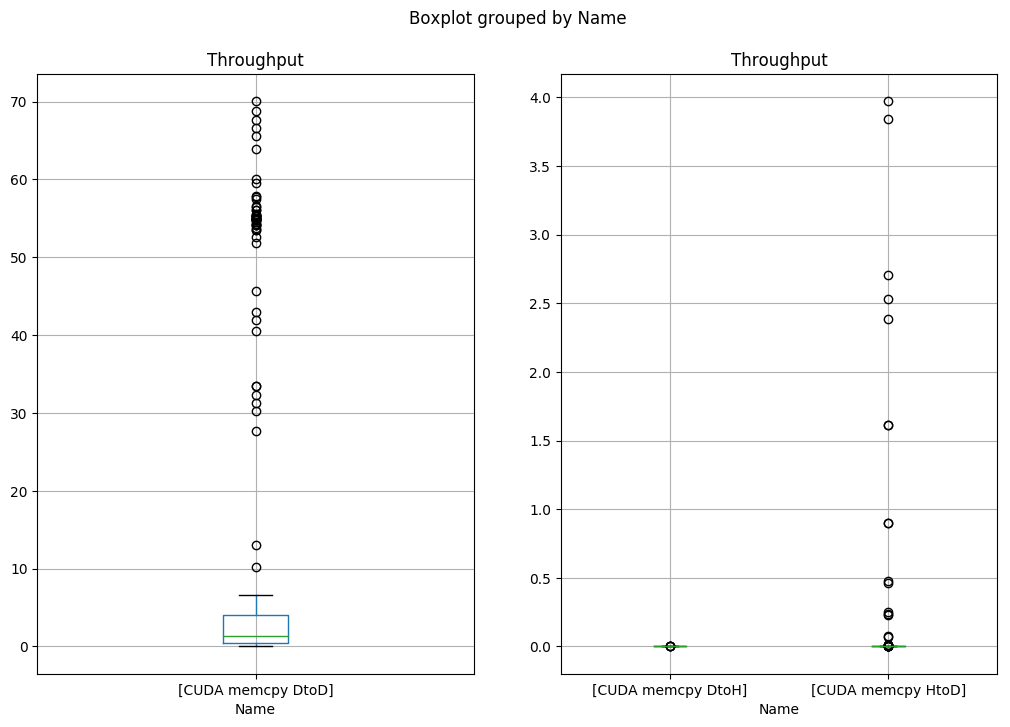

In [12]:
plt.rcParams['figure.figsize'] = 12,8
fig, axarr = plt.subplots(1,2)
dd.boxplot(column="Throughput",by="Name",ax=axarr[0])
dh.boxplot(column="Throughput",by="Name",ax=axarr[1])
#ax = plt.gca()
#ax.set_ylabel('Throughput (GB/s)')

In [13]:
print df_nvprof.columns
df_nvprof.iloc[90:95]

Index([u'Start', u'Duration', u'Size', u'Throughput', u'SrcMemType',
       u'DstMemType', u'Context', u'Stream', u'Name'],
      dtype='object')


,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name
93,1.397713,0.001184,0.000977,0.805468,Device,Device,1,14,[CUDA memcpy DtoD]
94,1.397717,0.001184,0.000977,0.805468,Device,Device,1,14,[CUDA memcpy DtoD]
95,1.397720,0.001184,0.000977,0.805468,Device,Device,1,14,[CUDA memcpy DtoD]
97,1.397740,0.001312,0.000244,0.181721,Device,Device,1,14,[CUDA memcpy DtoD]
98,1.397754,0.001344,0.000244,0.177395,Device,Device,1,14,[CUDA memcpy DtoD]


In [14]:
df_nvprof['FullName']  = df_nvprof.loc[:,'Name'] + " " + df_nvprof.loc[:,'SrcMemType']+ df_nvprof.loc[:,'DstMemType'].fillna("")

In [15]:
df_nvprof[pd.isnull(df_nvprof["FullName"])]

,Start,Duration,Size,Throughput,SrcMemType,DstMemType,Context,Stream,Name,FullName


In [16]:
# Convert unique values in column "FullName" to new columns
def mergeColumnNames(df_org):
    df = df_org.pivot(index="Start", columns="FullName", values = 'Throughput')
    df = df.fillna(0)  # Fill empty cells with 0-s
    return df

In [17]:
df_throughput = mergeColumnNames(df_nvprof)

In [18]:
df_throughput.iloc[:3]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice,[CUDA memset] Device
Start,,,,,
0.904099,0.0,0.0,0.0,0.000000,0.311654
1.381351,0.0,0.0,0.0,0.002910,0.000000
1.381518,0.0,0.0,0.0,0.003881,0.000000


In [25]:
df_memcpy = df_throughput.filter(regex=("^((?!memset).)*$"))
df_memcpy.iloc[:3]

FullName,[CUDA memcpy DtoD] DeviceDevice,[CUDA memcpy DtoH] DevicePinned,[CUDA memcpy HtoD] PageableDevice,[CUDA memcpy HtoD] PinnedDevice
Start,,,,
0.904099,0.0,0.0,0.0,0.000000
1.381351,0.0,0.0,0.0,0.002910
1.381518,0.0,0.0,0.0,0.003881


In [26]:
def appendMaxValues2ColumnNames(df,series):
    cols = len(df.columns)
    col_names = []
    for i in range(0,cols):
        name = df.columns[i].replace("[CUDA memcpy ","")
        name = name.replace("]","")
        col_names.append(series+name+" " +'{:.3f}'.format(df.iloc[:,i].max()))
    df.columns = col_names
    return df

In [27]:
df_memcpy = appendMaxValues2ColumnNames(df_memcpy,"")

In [28]:
df_memcpy.columns

Index([u'DtoD DeviceDevice 70.066', u'DtoH DevicePinned 0.006',
       u'HtoD PageableDevice 0.074', u'HtoD PinnedDevice 3.974'],
      dtype='object')

In [35]:
dd = df_memcpy.filter(regex=(".*DtoD.+"))
dd.iloc[:3]

,DtoD DeviceDevice 70.066
Start,
0.904099,0.0
1.381351,0.0
1.381518,0.0


In [36]:
dh = df_memcpy.filter(regex=(".*(HtoD|DtoH).*"))
dh.iloc[:3]

,DtoH DevicePinned 0.006,HtoD PageableDevice 0.074,HtoD PinnedDevice 3.974
Start,,,
0.904099,0.0,0.0,0.000000
1.381351,0.0,0.0,0.002910
1.381518,0.0,0.0,0.003881


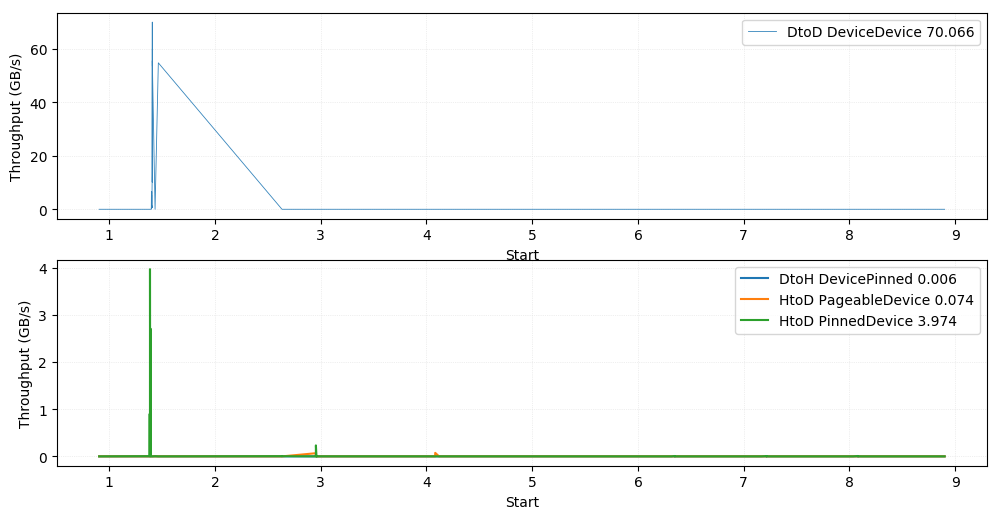

In [63]:
plt.rcParams['figure.figsize'] = 12,6
fig, axarr = plt.subplots(2)
dd.plot(linewidth=0.6,alpha=0.9,ax = axarr[0])
dh.plot(linewidth=0.6,alpha=0.9,ax = axarr[1])
for ax in axarr:
    ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    ax.set_ylabel('Throughput (GB/s)')

In [49]:
# PCI express x3 bandwidth
PCI3_band = 16 # GB/s

In [50]:
# Device DRAM bandwidth
# Memory clock rate
GHz=5
# Interface width
bit=256

DRAM_GBs=(GHz * 1e9 * (bit/8)) / 1e9
print DRAM_GBs

160.0


#### Normalize H<->D throughput

In [51]:
norm = df_memcpy.copy()
print type(df_memcpy),df_memcpy[:1].shape
print type(norm),norm[:1].shape
norm.iloc[:7]

<class 'pandas.core.frame.DataFrame'> (1, 4)
<class 'pandas.core.frame.DataFrame'> (1, 4)


,DtoD DeviceDevice 70.066,DtoH DevicePinned 0.006,HtoD PageableDevice 0.074,HtoD PinnedDevice 3.974
Start,,,,
0.904099,0.0,0.0,0.0,0.000000
1.381351,0.0,0.0,0.0,0.002910
1.381518,0.0,0.0,0.0,0.003881
1.381649,0.0,0.0,0.0,0.248353
1.381752,0.0,0.0,0.0,0.240341
1.381944,0.0,0.0,0.0,0.003881
1.382036,0.0,0.0,0.0,0.003881


In [57]:
df_memcpy[df_memcpy.iloc[:,0] > 60]

,DtoD DeviceDevice 70.066,DtoH DevicePinned 0.006,HtoD PageableDevice 0.074,HtoD PinnedDevice 3.974
Start,,,,
1.406253,63.844306,0.0,0.0,0.0
1.406306,66.535417,0.0,0.0,0.0
1.406329,67.583219,0.0,0.0,0.0
1.406514,65.519610,0.0,0.0,0.0
1.406610,70.065868,0.0,0.0,0.0
1.406740,68.733284,0.0,0.0,0.0
1.407341,60.070277,0.0,0.0,0.0


In [58]:
def normalize(x,max = 16):
    #print "max=",max 
    if isinstance(x,int) or isinstance(x,float):
        if x == 0:
            return 0
        else:
            x_ = float(x)
            max_ = float(max)
            norm = (x_/max_)*100
            #print x_,norm
            return norm
    elif x is None:
        return x
    else:
        print "Wrong parameter type:",type(x)

def normalize_df(x,max = 16):
    #print type(x)
    if isinstance(x,int) or isinstance(x,float):
        return normalize(x,max)
    else:
        #print x.values
        x = x.apply(normalize,max=max)
        #print "Returned:",type(x)
        #print x.values
        return x
    
       
norm.iloc[:,2:] = norm.iloc[:,2:].apply(normalize_df, max = PCI3_band)
norm.iloc[:,0] = norm.iloc[:,0].apply(normalize_df, max = DRAM_GBs)
norm[df_memcpy.iloc[:,0] > 60]

,DtoD DeviceDevice 70.066,DtoH DevicePinned 0.006,HtoD PageableDevice 0.074,HtoD PinnedDevice 3.974
Start,,,,
1.406253,39.902691,0.0,0.0,0.0
1.406306,41.584636,0.0,0.0,0.0
1.406329,42.239512,0.0,0.0,0.0
1.406514,40.949756,0.0,0.0,0.0
1.406610,43.791168,0.0,0.0,0.0
1.406740,42.958303,0.0,0.0,0.0
1.407341,37.543923,0.0,0.0,0.0


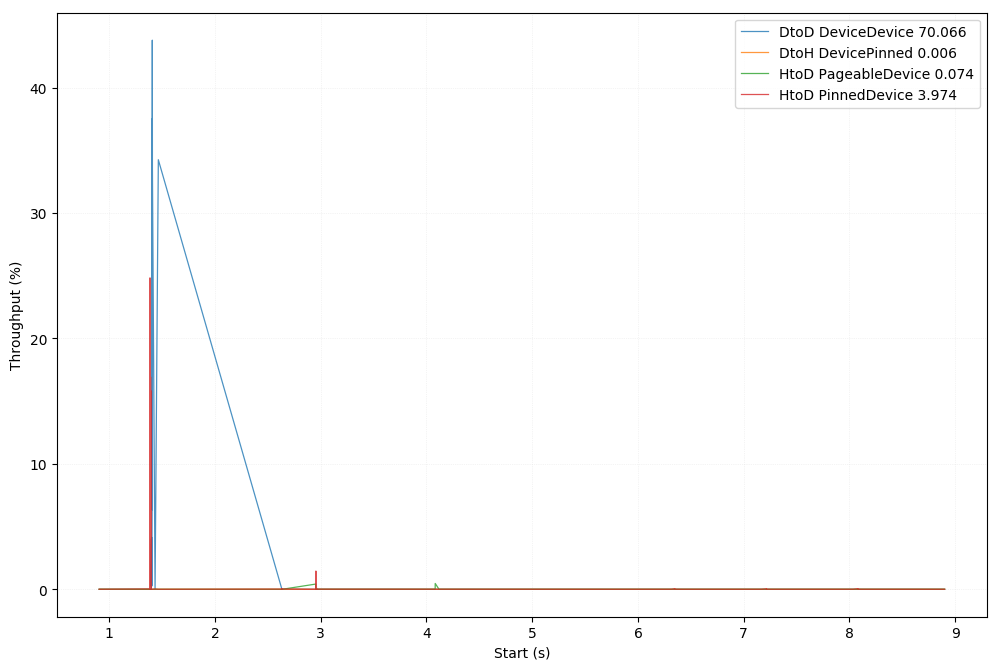

In [86]:
plt.rcParams['figure.figsize'] = 12,8
norm.plot(linewidth=0.9,alpha=0.8)
ax = plt.gca()
ax.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
ax.yaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5,alpha=0.7)
#ax.xaxis.set_major_locator(plt.MaxNLocator(24))
ax.set_xlabel('Start (s)')
ax.set_ylabel('Throughput (%)')
plt.show()

## Plot smi data

In [74]:
filename = filename_nvsmi_tf
print "Reading",filename

smi_data = pd.read_csv(filename)
smi_data.iloc[:3]
start = 0

Reading nvidia-smi-tfhp_combined.csv


In [75]:
# Parse date from readable format to seconds
def parseTime(date_time):
    global start
    dt_obj = datetime.datetime.strptime(date_time, "%Y/%m/%d %H:%M:%S.%f")
    seconds = 0
    if start == 0:
        start = dt_obj
    else:
        seconds = (dt_obj - start).total_seconds()
    return seconds

In [76]:
smi_data["sec"] = smi_data["timestamp"].apply(parseTime)
smi_data.iloc[:3]

,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%],sec
0,2018/01/24 08:53:30.947,Tesla M60,7613 MiB,0 MiB,96 %,7 %,0.000
1,2018/01/24 08:53:31.166,Tesla M60,7613 MiB,0 MiB,99 %,8 %,0.219
2,2018/01/24 08:53:31.307,Tesla M60,7613 MiB,0 MiB,98 %,8 %,0.360


In [77]:
smi_data.set_index("sec", drop=True, inplace=True)
smi_data.iloc[:3]

,timestamp,name,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%]
sec,,,,,,
0.000,2018/01/24 08:53:30.947,Tesla M60,7613 MiB,0 MiB,96 %,7 %
0.219,2018/01/24 08:53:31.166,Tesla M60,7613 MiB,0 MiB,99 %,8 %
0.360,2018/01/24 08:53:31.307,Tesla M60,7613 MiB,0 MiB,98 %,8 %


In [78]:
smi_data = smi_data.drop(columns = ['timestamp', ' name'])

In [79]:
pat = re.compile("[0-9\.]+")
# Extract float number from a string
def parseFloat(str):
    global pat
    f = pat.search(str)
    if f is not None:
        d = float(f.group())
        return d
    return None

In [80]:
smi_data = smi_data.applymap(parseFloat)
smi_data.iloc[:3]

,memory.total [MiB],memory.used [MiB],utilization.gpu [%],utilization.memory [%]
sec,,,,
0.000,7613.0,0.0,96.0,7.0
0.219,7613.0,0.0,99.0,8.0
0.360,7613.0,0.0,98.0,8.0


In [82]:
smi_MB = smi_data.filter(regex=(".*\[MiB.*"))
smi_pr = smi_data.filter(regex=(".*\[\%.*"))
smi_pr.iloc[-5:]

,utilization.gpu [%],utilization.memory [%]
sec,,
11.925,100.0,88.0
12.026,100.0,88.0
12.126,64.0,58.0
12.227,0.0,0.0
12.327,0.0,0.0


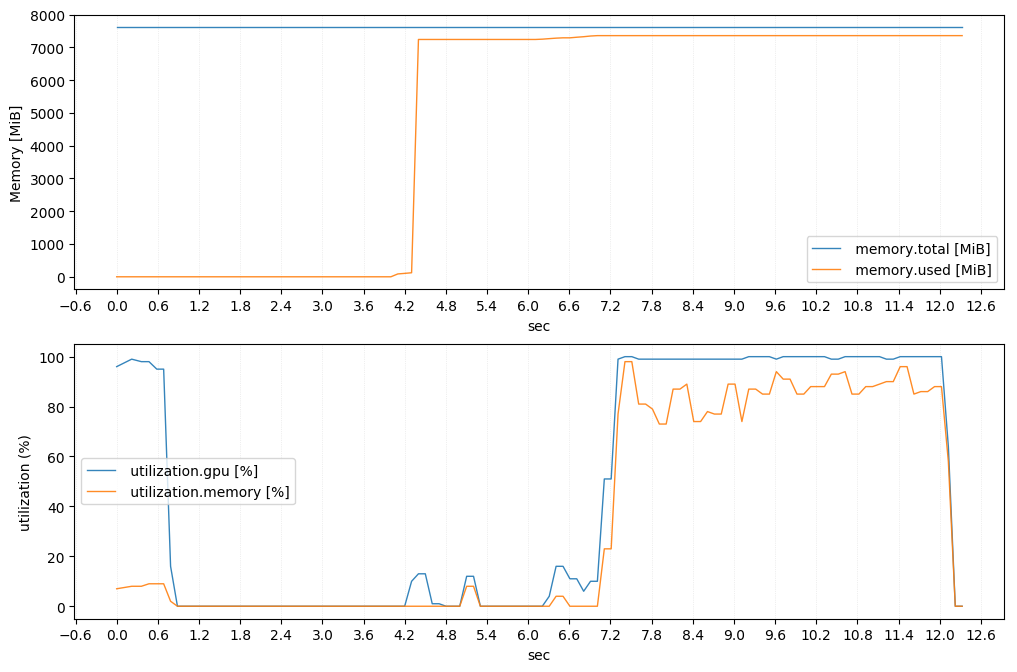

In [85]:
plt.rcParams['figure.figsize'] = 12,8
fig, axarr = plt.subplots(2)
smi_MB.plot(linewidth=1,alpha=0.9,ax = axarr[0])
smi_pr.plot(linewidth=1,alpha=0.9,ax = axarr[1])
axarr[0].set_ylabel('Memory [MiB]')
axarr[1].set_ylabel('utilization (%)')
for axis in axarr:
    axis.legend()
    axis.xaxis.grid(color="#e0e0e0", linestyle=":",linewidth=0.5)
    axis.xaxis.set_major_locator(plt.MaxNLocator(24))
    #axis.xaxis.set_major_locator(dates.SecondLocator(bysecond = range(120), interval = 10))
    #axis.xaxis.set_minor_locator(dates.MicrosecondLocator(interval = 1000))
    #axis.xaxis.set_major_formatter(dates.DateFormatter('%S:%f'))
plt.show()